In [20]:
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import umap
import h5py
from tqdm import tqdm
import sys
import os

In [2]:
# Define root directory
# root = os.path.dirname(os.path.abspath(__file__))
root = "."
sys.path.append(os.path.join(root, "..", "src"))
from default import DATAPATH, CONFIGPATH

# Load pathogen info
# pathogen_code = sys.argv[1]
pathogen_code = 'mtuberculosis'
df = pd.read_csv(os.path.join(CONFIGPATH, 'pathogens.csv'))
row = df.loc[df["code"].eq(pathogen_code)]
if row.empty: 
    raise SystemExit(f"Unknown code: {pathogen_code}")
pathogen = row.iloc[0]["pathogen"]

# Create output directory
OUTPUT = os.path.join(root, "..", "output")

In [3]:
def load_ecfp_all(h5_path):
    """Load all ECFP (Morgan count) fingerprints.

    Parameters
    ----------
    h5_path : str
        Path to the HDF5 file containing datasets "SMILES" and "X_morgan".

    Returns
    -------
    dict[str, np.ndarray]
        Mapping {chembl_id: fingerprint (np.int8, shape (nBits,))}.
    """
    with h5py.File(h5_path, "r") as f:
        meta = f["SMILES"][:, 3].astype(str)
        fps  = f["X_morgan"][:]  # Load ALL

    return {cid: fp for cid, fp in zip(meta, fps)}

# Loading Morgan fingerprints
PATH_TO_ECFPs = os.path.join(DATAPATH, "chembl_processed", "ChEMBL_ECFPs.h5")
ecfps = load_ecfp_all(PATH_TO_ECFPs)

In [4]:
def fit_umap_reference(ecfp_dict, n_ref=10_000, seed=42):
    """
    Sample n_ref compounds, fit UMAP, and persist:
      - fitted reducer
      - reference ids
      - reference embedding
    """

    # Sample n_ref ids
    ids_all = np.array(list(ecfp_dict.keys()))
    rng = np.random.default_rng(seed)
    ref_ids = rng.choice(ids_all, size=n_ref, replace=False)

    # Build matrix
    X_ref = np.stack([ecfp_dict[i] for i in ref_ids], axis=0)

    # Binarize
    X_ref = (X_ref > 0).astype(np.uint8)

    # UMAP prefers float32 for speed/memory
    X_ref = X_ref.astype(np.float32, copy=False)

    reducer = umap.UMAP(
        n_neighbors=30,
        min_dist=0.15,
        n_components=2,
        metric="jaccard",
        random_state=seed,
        verbose=True,
    )

    emb_ref = reducer.fit_transform(X_ref)

    # os.makedirs(outdir, exist_ok=True)
    # joblib.dump(reducer, os.path.join(outdir, "umap_reducer.joblib"))
    # np.save(os.path.join(outdir, "umap_ref_ids.npy"), ref_ids)
    # np.save(os.path.join(outdir, "umap_ref_emb.npy"), emb_ref)

    return reducer, ref_ids, emb_ref

reducer, ref_ids, ref_emb = fit_umap_reference(ecfps, n_ref=10_000, seed=42)

/home/acomajuncosa/miniconda3/envs/camt/lib/python3.10/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='jaccard',
     min_dist=0.15, n_neighbors=30, random_state=42, verbose=True)
Construct fuzzy simplicial set
Thu Jan 29 16:36:52 2026 Finding Nearest Neighbors
Thu Jan 29 16:36:52 2026 Building RP forest with 10 trees
Thu Jan 29 16:36:56 2026 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Thu Jan 29 16:37:06 2026 Finished Nearest Neighbor Search
Thu Jan 29 16:37:07 2026 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jan 29 16:37:20 2026 Finished embedding


In [5]:
# Number of compounds, activities and assays
raw = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "mtuberculosis_ChEMBL_raw_data.csv.gz"))
activities_raw = len(raw)
compounds_raw = len(set(raw['compound_chembl_id']))
cleaned = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "mtuberculosis_ChEMBL_cleaned_data.csv.gz"))
activities_cleaned = len(cleaned)
compounds_cleaned = len(set(cleaned['compound_chembl_id']))
assays_raw = len(pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_raw.csv")))
assays_cleaned = len(pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv")))
del raw, cleaned

In [6]:
# Assay type
df = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv"))
assay_type = Counter(df['assay_type'])
assay_type = [assay_type['F'] / sum(assay_type.values()), (assay_type['F'] + assay_type['B']) / sum(assay_type.values()), 1][::-1]
target_type = Counter(df['target_type'])
target_type = [target_type['ORGANISM'] / sum(target_type.values()), (target_type['ORGANISM'] + target_type['SINGLE PROTEIN']) / sum(target_type.values()), 1][::-1]
assay_organism = Counter(df['assay_organism'])
assay_organism = [assay_organism[pathogen_code] / sum(assay_organism.values()), 1]

In [7]:
# Load reference compounds from pathogen
reference_compounds = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "compound_counts.csv.gz"))[:1_000]['compound_chembl_id']
X_pathogen = np.array([ecfps[i] for i in reference_compounds])
X_pathogen = (X_pathogen > 0).astype(np.uint8)
X_pathogen = reducer.transform(X_pathogen)

Thu Jan 29 16:37:25 2026 Worst tree score: 0.42500000
Thu Jan 29 16:37:25 2026 Mean tree score: 0.44299000
Thu Jan 29 16:37:25 2026 Best tree score: 0.46760000
Thu Jan 29 16:37:26 2026 Forward diversification reduced edges from 300000 to 116309
Thu Jan 29 16:37:28 2026 Reverse diversification reduced edges from 116309 to 116199
Thu Jan 29 16:37:30 2026 Degree pruning reduced edges from 144226 to 144216
Thu Jan 29 16:37:30 2026 Resorting data and graph based on tree order
Thu Jan 29 16:37:30 2026 Building and compiling search function
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [14]:
# Cumulative coverage chemical space per assay
ASSAYS_CLEANED = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "assays_cleaned.csv"))
assays_pathogen = set(ASSAYS_CLEANED['assay_id'])

# Dict mapping assay_id, activity_type and unit to a set of compound ChEMBL IDs
ChEMBL = pd.read_csv(os.path.join(OUTPUT, pathogen_code, f"{pathogen_code}_ChEMBL_cleaned_data.csv.gz"), low_memory=False)
compounds_pathogen = set(ChEMBL['compound_chembl_id'])
ASSAY_TO_COMPOUNDS = defaultdict(set)
for assay_id, activity_type, unit, compound_chembl_id in ChEMBL[["assay_chembl_id", "activity_type", "unit", "compound_chembl_id"]].values:
    if assay_id in assays_pathogen:
        ASSAY_TO_COMPOUNDS[(assay_id, activity_type, unit)].add(compound_chembl_id)
del ChEMBL

In [ ]:
CUM_CPDS = set()
CUM_PROP = []
for assay_id, activity_type, unit in tqdm(ASSAYS_CLEANED[["assay_id", "activity_type", "unit"]].values):
    CUM_CPDS = CUM_CPDS.union(ASSAY_TO_COMPOUNDS[(assay_id, activity_type, unit)])
    CUM_PROP.append(len(CUM_CPDS) / len(compounds_pathogen))
ASSAYS_CLEANED['cum_prop'] = CUM_PROP

100%|██████████| 10532/10532 [00:50<00:00, 207.16it/s]


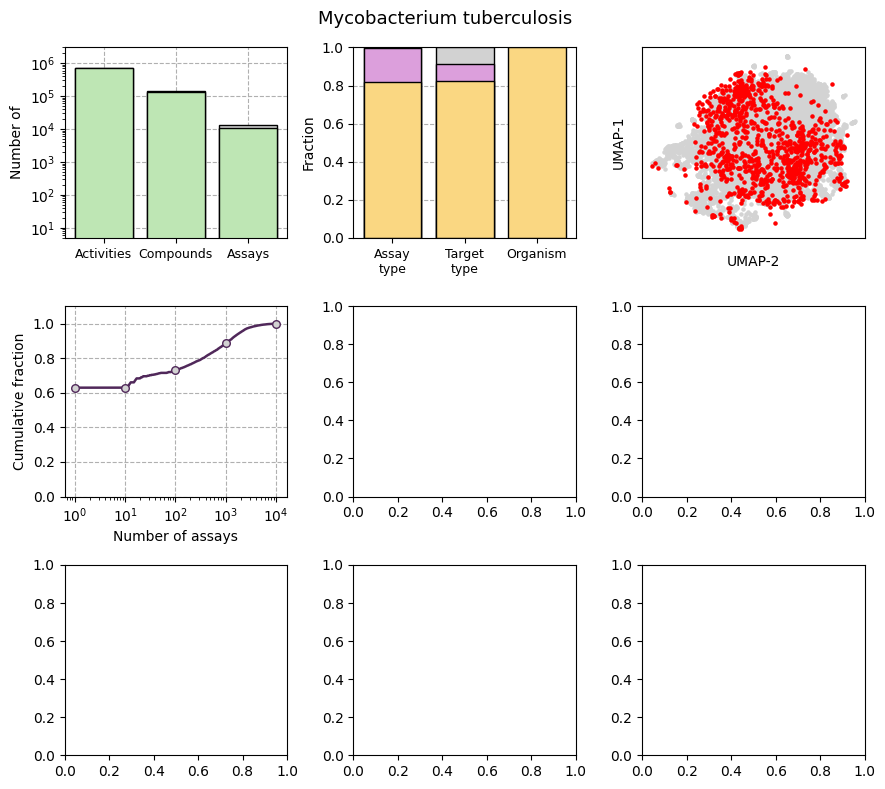

In [53]:
fig, ax = plt.subplots(3, 3, figsize=(9, 8))

# Number of compounds, activities and assays
ax[0][0].bar([0, 0], [activities_raw, activities_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].bar([1, 1], [compounds_raw, compounds_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].bar([2, 2], [assays_raw, assays_cleaned], color=['#D2D2D2', '#BEE6B4'], ec='k', zorder=2)
ax[0][0].grid(linestyle='--', zorder=-2)
ax[0][0].set_yscale('log')
ax[0][0].set_yticks([10**1, 10**2, 10**3, 10**4, 10**5, 10**6])
ax[0][0].set_ylim([5, 3*10**6])
ax[0][0].set_xticks([0, 1, 2])
ax[0][0].set_xticklabels(['Activities', 'Compounds', 'Assays'], size=9)
ax[0][0].set_ylabel("Number of")

# Fraction assays
ax[0][1].bar([0, 0, 0], assay_type, zorder=2, color=['#D2D2D2', '#DC9FDC', '#FAD782'], ec='k')
ax[0][1].bar([1, 1, 1], target_type, zorder=2, color=['#D2D2D2', '#DC9FDC', '#FAD782'], ec='k')
ax[0][1].bar([2, 2], assay_organism, zorder=2, color=['#D2D2D2', '#FAD782'], ec='k')
ax[0][1].set_ylabel("Fraction")
ax[0][1].set_ylim([0, 1])
ax[0][1].grid(linestyle='--', zorder=-2)
ax[0][1].set_xticks([0, 1, 2])
ax[0][1].set_xticklabels(['Assay\ntype', 'Target\ntype', 'Organism'], size=9)

# 2D visualization
ax[0][2].scatter(ref_emb[:, 0], ref_emb[:, 1], s=5, c='lightgray')
ax[0][2].scatter(X_pathogen[:, 0], X_pathogen[:, 1], s=5, c='r')
ax[0][2].set_yticks([])
ax[0][2].set_xticks([])
ax[0][2].set_ylabel("UMAP-1", labelpad=12)
ax[0][2].set_xlabel('UMAP-2', labelpad=12)

# Cumulative fraction chemical space
ax[1][0].set_ylim([0, 1.1])
ax[1][0].grid(linestyle='--', zorder=-2)
ax[1][0].plot([i+1 for i in range(len(CUM_PROP))], CUM_PROP, c="#50285A", lw=1.8)
x = [1, 10, 100, 1000, 10000]
y = [CUM_PROP[i-1] for i in x]
ax[1][0].scatter(x, y, zorder=2, ec="#50285A", s=30, c='#D2D2D2')
ax[1][0].set_xlabel("Number of assays")
ax[1][0].set_ylabel("Cumulative fraction")
ax[1][0].set_xscale('log')
ax[1][0].set_xticks([1, 10, 100, 1000, 10000])

plt.suptitle(pathogen, size=13)
plt.tight_layout()
plt.show()